# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
!pip install imageio
!pip install progressbar

In [1]:
from unityagents import UnityEnvironment
import numpy as np
import pylab as plt
import time
import torch
import os

In [2]:
import progressbar as pb

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [3]:
env = UnityEnvironment(file_name="Tennis_Linux/Tennis.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
agents_number = num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_dim = action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_dim = state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

In [6]:
import time
for i in range(1, 6):                                      # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        time.sleep(0.1)
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

Score (max over agents) from episode 1: 0.0
Score (max over agents) from episode 2: 0.0
Score (max over agents) from episode 3: 0.0
Score (max over agents) from episode 4: 0.0
Score (max over agents) from episode 5: 0.0


When finished, you can close the environment.

In [69]:
env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [7]:
%load_ext autoreload

In [8]:
%autoreload 2

In [9]:
from buffers import ReplayBuffer
from utilities import transpose_list, transpose_to_tensor
from torch import tensor

In [10]:
# for saving gif
import imageio

In [11]:
def moving_average(a, n=100) :
    ret = np.cumsum(np.concatenate([np.zeros(n), a]), dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    n_arr = np.clip(np.arange(1, len(a)+1), 1, n)
    return ret[n:] / n_arr

In [12]:
def seeding(seed=1):
    np.random.seed(seed)
    torch.manual_seed(seed)

def pre_process(entity, batchsize):
    processed_entity = []
    for j in range(3):
        list = []
        for i in range(batchsize):
            b = entity[i][j]
            list.append(b)
        c = torch.Tensor(list)
        processed_entity.append(c)
    return processed_entity

In [13]:
class Task:
    def __init__(self, env, brain_name):
        self.env = env
        self.brain_name = brain_name
        self.reset()
        
        uniform = torch.distributions.Uniform(-1, 1)
        uniform._batch_shape = torch.Size([1, env.brains[brain_name].vector_action_space_size])
        
        self.action_space = uniform
        
    def reset(self, train_mode=True):
        out = self.env.reset(train_mode=train_mode)[brain_name]     # reset the environment
        return out.vector_observations.astype(np.float32)
    
    def step(self, action):
        out = env.step(action)[self.brain_name]
        state = out.vector_observations.astype(np.float32)
        rewards = out.rewards
        done = out.local_done
        info = out.text_observations
        return (state, rewards, done, info)

In [14]:
task = Task(env, brain_name)

In [15]:
from maddpg import MADDPG
maddpg = MADDPG(state_dim, action_dim, agents_number)

In [16]:
print(maddpg.maddpg_agent[0].actor)
print(maddpg.maddpg_agent[0].critic)

ActorBody(
  (layers): ModuleList(
    (0): Linear(in_features=24, out_features=100, bias=True)
    (1): Linear(in_features=100, out_features=100, bias=True)
    (2): Linear(in_features=100, out_features=2, bias=True)
  )
)
CriticBody(
  (layers): ModuleList(
    (0): Linear(in_features=24, out_features=100, bias=True)
    (1): Linear(in_features=102, out_features=100, bias=True)
    (2): Linear(in_features=100, out_features=1, bias=True)
  )
)


In [65]:
seeding(12319)

Observations:
    * At least 13 iter per episode
    * Average 16 iterations per episode (poor)

In [47]:
# number of training episodes.
# change this to higher number to experiment. say 30000.
number_of_episodes = 20000
max_episode_length = 1000
batch_size = 64
buffer_size = int(1e5)
warm_up_period = 400 # iterations

# amplitude of OU noise
# this slowly decreases to 0
noise = 1
noise_reduction = 0.999

# how many episodes before update
episode_per_update = 1
episode_score_every = 100
save_interval = 200

model_dir= os.getcwd()+"/model_dir"

os.makedirs(model_dir, exist_ok=True)

# keep 5000 episodes worth of replay
buffer = ReplayBuffer(batch_size, buffer_size)

# initialize policy and critic
maddpg = MADDPG(state_dim, action_dim, agents_number, tau=0.005)
all_rewards = np.zeros((number_of_episodes, agents_number))
iter_per_eposide = np.zeros(number_of_episodes)

In [ ]:
# training loop
# show progressbar
widget = ['episode: ', pb.Counter(),'/',str(number_of_episodes),' ', 
          pb.Percentage(), ' ', pb.ETA(), ' ', pb.Bar(marker=pb.RotatingMarker()), ' ' ]

timer = pb.ProgressBar(widgets=widget, maxval=number_of_episodes).start()

# use keep_awake to keep workspace from disconnecting
reward_this_episode = np.zeros(num_agents)
iteration = 0

for episode in range(number_of_episodes):

    timer.update(episode)
    state = task.reset()
    reward_this_episode[:] = 0

    for frame_idx in range(max_episode_length):
        iteration += 1

        actions = maddpg.act(state, noise=noise)
        noise *= noise_reduction

        actions_array = torch.stack(actions).detach().cpu().numpy().astype(np.float32)

        # step forward one frame
        next_state, rewards, dones, info = task.step(actions_array)

        # add data to buffer
        buffer.add(state, actions_array, rewards, next_state, dones)

        reward_this_episode += rewards
        
        state = next_state
        iter_per_eposide[episode] += 1
        
        if any(dones):
            break

    # update once after every episode_per_update
    if len(buffer) > batch_size and iteration > warm_up_period:
        for agent_number in range(num_agents):
            samples = buffer.sample()
            maddpg.update(samples, agent_number)
        maddpg.update_targets() #soft update the target network towards the actual networks

    all_rewards[episode] = reward_this_episode

    if (episode+1) % episode_score_every == 1 or episode == number_of_episodes-1:
        _r = all_rewards[max(episode-100, 0):episode, :]
        print(f'Ep {episode:4}. Rewards avg 100: {np.max(_r, axis=1).mean():5.2} = {_r[:, 0].mean():5.2}  --  {_r[:, 1].mean():5.2}')
        
    #if episode > 400 and abs(np.max(all_rewards, axis=1)[-400:].mean()) < 0.00000001:
    #    print("Breaking. No use.")
    #    break

        #saving model
    if ((episode+1) % save_interval == 0):
        save_dict_list = []
        for agent_i in range(agents_number):
            save_dict = {
                'actor_params' : maddpg.maddpg_agent[agent_i].actor.state_dict(),
                'actor_optim_params': maddpg.maddpg_agent[agent_i].actor_optimizer.state_dict(),
                'critic_params' : maddpg.maddpg_agent[agent_i].critic.state_dict(),
                'critic_optim_params' : maddpg.maddpg_agent[agent_i].critic_optimizer.state_dict()
            }
            save_dict_list.append(save_dict)

        torch.save(save_dict_list, os.path.join(model_dir, 'episode-{}.pt'.format(episode)))

timer.finish()


<ipython-input-48-075e63f15352>:51: RuntimeWarning: Mean of empty slice.     | 
  print(f'Ep {episode:4}. Rewards avg 100: {np.max(_r, axis=1).mean():5.2} = {_r[:, 0].mean():5.2}  --  {_r[:, 1].mean():5.2}')
/home/kretyn/courses/DeRL/venv/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Ep    0. Rewards avg 100:   nan =   nan  --    nan


/home/kretyn/courses/DeRL/venv/lib/python3.8/site-packages/torch/nn/modules/loss.py:798: UserWarning: Using a target size (torch.Size([64, 64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Ep  100. Rewards avg 100:   0.0 = -0.0042  --  -0.0058


Ep  200. Rewards avg 100:   0.0 = -0.0043  --  -0.0057


Ep  300. Rewards avg 100:   0.0 = -0.0046  --  -0.0054


Ep  400. Rewards avg 100:   0.0 = -0.0052  --  -0.0048


Ep  500. Rewards avg 100:   0.0 = -0.0055  --  -0.0045


Ep  600. Rewards avg 100:   0.0 = -0.0054  --  -0.0046


Ep  700. Rewards avg 100:   0.0 = -0.0049  --  -0.0051


Ep  800. Rewards avg 100:   0.0 = -0.0047  --  -0.0053


Ep  900. Rewards avg 100:   0.0 = -0.0052  --  -0.0048


Ep 1000. Rewards avg 100:   0.0 = -0.0045  --  -0.0055


Ep 1100. Rewards avg 100:   0.0 = -0.0049  --  -0.0051


Ep 1200. Rewards avg 100:   0.0 = -0.0044  --  -0.0056


Ep 1300. Rewards avg 100:   0.0 = -0.0048  --  -0.0052


Ep 1400. Rewards avg 100:   0.0 = -0.0057  --  -0.0043


Ep 1500. Rewards avg 100:   0.0 = -0.005  --  -0.005


Ep 1600. Rewards avg 100:   0.0 = -0.0053  --  -0.0047


Ep 1700. Rewards avg 100:   0.0 = -0.0051  --  -0.0049


Ep 1800. Rewards avg 100:   0.0 = -0.0054  --  -0.0046


Ep 1900. Rewards avg 100:   0.0 = -0.005  --  -0.005


Ep 2000. Rewards avg 100:   0.0 = -0.0052  --  -0.0048


Ep 2100. Rewards avg 100:   0.0 = -0.005  --  -0.005


Ep 2200. Rewards avg 100:   0.0 = -0.0047  --  -0.0053


Ep 2300. Rewards avg 100:   0.0 = -0.0057  --  -0.0043


Ep 2400. Rewards avg 100:   0.0 = -0.0054  --  -0.0046


Ep 2500. Rewards avg 100:   0.0 = -0.0042  --  -0.0058


Ep 2600. Rewards avg 100:   0.0 = -0.0049  --  -0.0051


Ep 2700. Rewards avg 100:   0.0 = -0.0049  --  -0.0051


Ep 2800. Rewards avg 100:   0.0 = -0.005  --  -0.005


Ep 2900. Rewards avg 100:   0.0 = -0.0049  --  -0.0051


Ep 3000. Rewards avg 100:   0.0 = -0.0041  --  -0.0059


Ep 3100. Rewards avg 100:   0.0 = -0.0049  --  -0.0051


Ep 3200. Rewards avg 100:   0.0 = -0.0049  --  -0.0051


Ep 3300. Rewards avg 100:   0.0 = -0.0045  --  -0.0055


Ep 3400. Rewards avg 100:   0.0 = -0.0053  --  -0.0047


Ep 3500. Rewards avg 100:   0.0 = -0.0054  --  -0.0046


Ep 3600. Rewards avg 100:   0.0 = -0.0048  --  -0.0052


Ep 3700. Rewards avg 100:   0.0 = -0.0054  --  -0.0046


Ep 3800. Rewards avg 100:   0.0 = -0.0057  --  -0.0043


Ep 3900. Rewards avg 100:   0.0 = -0.0057  --  -0.0043


Ep 4000. Rewards avg 100:   0.0 = -0.0059  --  -0.0041


Ep 4100. Rewards avg 100:   0.0 = -0.0049  --  -0.0051


Ep 4200. Rewards avg 100:   0.0 = -0.0048  --  -0.0052


Ep 4300. Rewards avg 100:   0.0 = -0.0051  --  -0.0049


Ep 4400. Rewards avg 100:   0.0 = -0.0044  --  -0.0056


Ep 4500. Rewards avg 100:   0.0 = -0.0052  --  -0.0048


Ep 4600. Rewards avg 100:   0.0 = -0.006  --  -0.004


Ep 4700. Rewards avg 100:   0.0 = -0.0048  --  -0.0052


Ep 4800. Rewards avg 100:   0.0 = -0.005  --  -0.005


Ep 4900. Rewards avg 100:   0.0 = -0.0042  --  -0.0058


Ep 5000. Rewards avg 100:   0.0 = -0.0051  --  -0.0049


Ep 5100. Rewards avg 100:   0.0 = -0.0054  --  -0.0046


Ep 5200. Rewards avg 100:   0.0 = -0.0053  --  -0.0047


Ep 5300. Rewards avg 100:   0.0 = -0.0045  --  -0.0055


Ep 5400. Rewards avg 100:   0.0 = -0.0046  --  -0.0054


Ep 5500. Rewards avg 100:   0.0 = -0.0046  --  -0.0054


Ep 5600. Rewards avg 100: 0.001 = -0.0043  --  -0.0047


Ep 5700. Rewards avg 100: 0.003 = -0.002  --  -0.005


Ep 5800. Rewards avg 100:   0.0 = -0.0047  --  -0.0053


Ep 5900. Rewards avg 100:   0.0 = -0.004  --  -0.006


Ep 6000. Rewards avg 100:   0.0 = -0.0048  --  -0.0052


Ep 6100. Rewards avg 100:   0.0 = -0.0047  --  -0.0053


Ep 6200. Rewards avg 100:   0.0 = -0.0047  --  -0.0053


Ep 6300. Rewards avg 100:   0.0 = -0.0053  --  -0.0047


Ep 6400. Rewards avg 100:   0.0 = -0.005  --  -0.005


Ep 6500. Rewards avg 100:   0.0 = -0.0051  --  -0.0049


Ep 6600. Rewards avg 100: 0.002 = -0.0028  --  -0.0042


Ep 6700. Rewards avg 100:   0.0 = -0.0057  --  -0.0043


Ep 6800. Rewards avg 100:   0.0 = -0.0052  --  -0.0048


Ep 6900. Rewards avg 100:   0.0 = -0.004  --  -0.006


Ep 7000. Rewards avg 100:   0.0 = -0.0052  --  -0.0048


Ep 7100. Rewards avg 100:   0.0 = -0.0047  --  -0.0053


Ep 7200. Rewards avg 100:   0.0 = -0.0061  --  -0.0039


Ep 7300. Rewards avg 100:   0.0 = -0.0054  --  -0.0046


Ep 7400. Rewards avg 100:   0.0 = -0.0045  --  -0.0055


Ep 7500. Rewards avg 100:   0.0 = -0.0062  --  -0.0038


Ep 7600. Rewards avg 100:   0.0 = -0.005  --  -0.005


Ep 7700. Rewards avg 100:   0.0 = -0.0056  --  -0.0044


Ep 7800. Rewards avg 100:   0.0 = -0.0041  --  -0.0059


Ep 7900. Rewards avg 100:   0.0 = -0.0049  --  -0.0051


Ep 8000. Rewards avg 100:   0.0 = -0.0056  --  -0.0044


Ep 8100. Rewards avg 100:   0.0 = -0.0042  --  -0.0058


Ep 8200. Rewards avg 100:   0.0 = -0.0054  --  -0.0046


Ep 8300. Rewards avg 100:   0.0 = -0.0047  --  -0.0053


Ep 8400. Rewards avg 100:   0.0 = -0.0053  --  -0.0047


Ep 8500. Rewards avg 100:   0.0 = -0.0054  --  -0.0046


Ep 8600. Rewards avg 100:   0.0 = -0.005  --  -0.005


Ep 8700. Rewards avg 100:   0.0 = -0.0056  --  -0.0044


Ep 8800. Rewards avg 100:   0.0 = -0.0051  --  -0.0049


Ep 8900. Rewards avg 100:   0.0 = -0.0045  --  -0.0055


Ep 9000. Rewards avg 100:   0.0 = -0.005  --  -0.005


Ep 9100. Rewards avg 100:   0.0 = -0.0055  --  -0.0045


Ep 9200. Rewards avg 100:   0.0 = -0.0052  --  -0.0048


Ep 9300. Rewards avg 100:   0.0 = -0.005  --  -0.005


Ep 9400. Rewards avg 100:   0.0 = -0.0045  --  -0.0055


Ep 9500. Rewards avg 100:   0.0 = -0.0052  --  -0.0048


Ep 9600. Rewards avg 100:   0.0 = -0.0041  --  -0.0059


Ep 9700. Rewards avg 100:   0.0 = -0.0046  --  -0.0054


Ep 9800. Rewards avg 100:   0.0 = -0.0047  --  -0.0053


Ep 9900. Rewards avg 100:   0.0 = -0.0048  --  -0.0052


Ep 10000. Rewards avg 100:   0.0 = -0.0049  --  -0.0051


Ep 10100. Rewards avg 100:   0.0 = -0.0049  --  -0.0051


Ep 10200. Rewards avg 100:   0.0 = -0.0047  --  -0.0053


Ep 10300. Rewards avg 100:   0.0 = -0.0047  --  -0.0053


Ep 10400. Rewards avg 100:   0.0 = -0.0056  --  -0.0044


Ep 10500. Rewards avg 100:   0.0 = -0.0046  --  -0.0054


Ep 10600. Rewards avg 100:   0.0 = -0.005  --  -0.005


Ep 10700. Rewards avg 100:   0.0 = -0.0053  --  -0.0047


Ep 10800. Rewards avg 100:   0.0 = -0.0048  --  -0.0052


Ep 10900. Rewards avg 100:   0.0 = -0.0045  --  -0.0055


Ep 11000. Rewards avg 100:   0.0 = -0.0046  --  -0.0054


Ep 11100. Rewards avg 100: 0.011 = 0.0074  --  -0.0064


Ep 11200. Rewards avg 100: 0.002 = -0.0028  --  -0.0052


Ep 11300. Rewards avg 100: 0.008 = 0.0032  --  -0.0052


Ep 11400. Rewards avg 100: 0.009 = 0.0042  --  -0.0053


Ep 11500. Rewards avg 100: 0.002 = -0.0023  --  -0.0057


Ep 11600. Rewards avg 100: 0.005 = 0.0002  --  -0.0052


Ep 11700. Rewards avg 100: 0.024 = 0.021  --  -0.0072


Ep 11800. Rewards avg 100: 0.012 = 0.0083  --  -0.0063


Ep 11900. Rewards avg 100: 0.003 = -0.0013  --  -0.0057


Ep 12000. Rewards avg 100:   0.0 = -0.004  --  -0.006


Ep 12100. Rewards avg 100:   0.0 = -0.0057  --  -0.0043


Ep 12200. Rewards avg 100:   0.0 = -0.0051  --  -0.0049


Ep 12300. Rewards avg 100:   0.0 = -0.0042  --  -0.0058


Ep 12400. Rewards avg 100:   0.0 = -0.0046  --  -0.0054


Ep 12500. Rewards avg 100:   0.0 = -0.0048  --  -0.0052


Ep 12600. Rewards avg 100:   0.0 = -0.0053  --  -0.0047


Ep 12700. Rewards avg 100:   0.0 = -0.0049  --  -0.0051


Ep 12800. Rewards avg 100:   0.0 = -0.0048  --  -0.0052


Ep 12900. Rewards avg 100:   0.0 = -0.0055  --  -0.0045


Ep 13000. Rewards avg 100:   0.0 = -0.0044  --  -0.0056


Ep 13100. Rewards avg 100:   0.0 = -0.0052  --  -0.0048


Ep 13200. Rewards avg 100:   0.0 = -0.0045  --  -0.0055


Ep 13300. Rewards avg 100:   0.0 = -0.0049  --  -0.0051


Ep 13400. Rewards avg 100:   0.0 = -0.0046  --  -0.0054


Ep 13500. Rewards avg 100:   0.0 = -0.0051  --  -0.0049


Ep 13600. Rewards avg 100:   0.0 = -0.0053  --  -0.0047


Ep 13700. Rewards avg 100:   0.0 = -0.0052  --  -0.0048


Ep 13800. Rewards avg 100:   0.0 = -0.0045  --  -0.0055


Ep 13900. Rewards avg 100: 0.001 = -0.0034  --  -0.0056


Ep 14000. Rewards avg 100:   0.0 = -0.0059  --  -0.0041


Ep 14100. Rewards avg 100:   0.0 = -0.0045  --  -0.0055


Ep 14200. Rewards avg 100:   0.0 = -0.0057  --  -0.0043


Ep 14300. Rewards avg 100:   0.0 = -0.0056  --  -0.0044


Ep 14400. Rewards avg 100:   0.0 = -0.0053  --  -0.0047


Ep 14500. Rewards avg 100: 0.005 = 0.0004  --  -0.0054


Ep 14600. Rewards avg 100: 0.008 = 0.003  --  -0.005


Ep 14700. Rewards avg 100:   0.0 = -0.0055  --  -0.0045


Ep 14800. Rewards avg 100: 0.009 = 0.0053  --  -0.0063


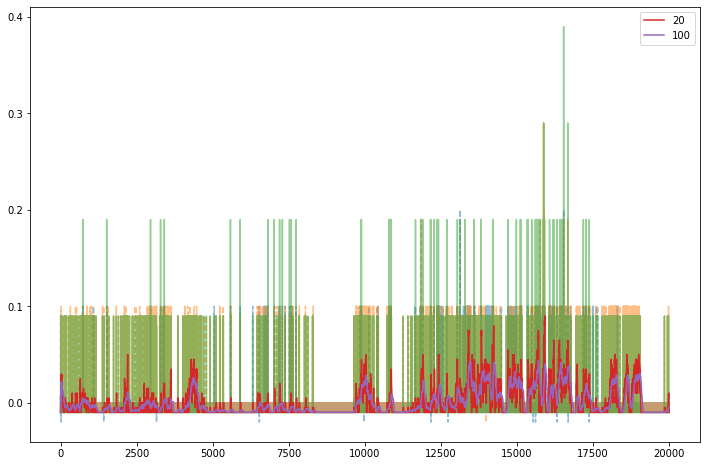

In [45]:
plt.figure(figsize=(12,8))
all_rewards_total = np.sum(all_rewards, axis=1)
plt.plot(all_rewards, '--', alpha=0.5)
plt.plot(all_rewards_total, alpha=0.5)
plt.plot(moving_average(all_rewards_total, 20), label='20')
plt.plot(moving_average(all_rewards_total), label='100')
plt.legend()

(0.0, 126.48)

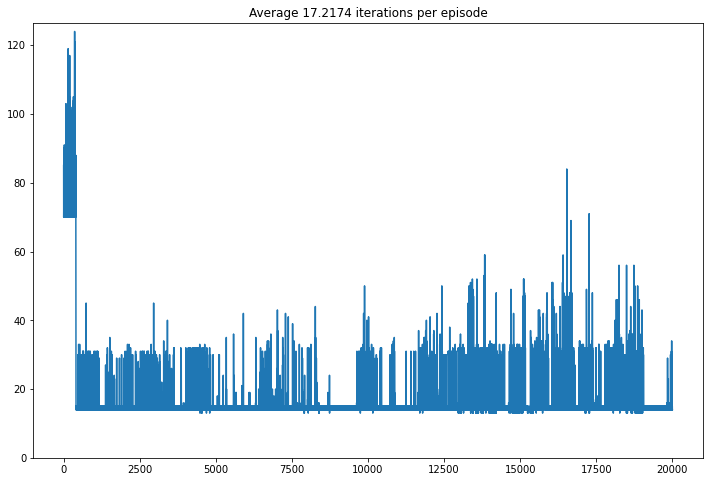

In [46]:
plt.figure(figsize=(12,8))
plt.plot(iter_per_eposide)
#plt.plot(np.cumsum(iter_per_eposide))
plt.title(f'Average {iter_per_eposide.mean()} iterations per episode')
plt.ylim((0, max(iter_per_eposide)*1.02))

In [67]:
states = out[0]
actions = out[1]
print(f"state: {states.shape}")
print(f"actions: {actions.shape}")

state: torch.Size([128, 2, 24])
actions: torch.Size([128, 2, 2])


In [60]:
device = torch.device('cuda')

In [81]:
%%timeit
state, action, reward, next_state, done = samples
reward = maddpg.reward_normalizer(reward)

agent = maddpg.maddpg_agent[agent_number]
agent.critic_optimizer.zero_grad()

#critic loss = batch mean of (y- Q(s,a) from target network)^2
#y = reward of this timestep + discount * Q(st+1,at+1) from target network
target_actions = maddpg.target_act(next_state)
target_actions = torch.cat(target_actions, dim=1).view(-1, len(maddpg.maddpg_agent), maddpg.action_dim)

# target_critic_input = torch.cat((state, target_actions), dim=2).to(device)
agent_state = state.select(1, agent_number)
agent_action = action.select(1, agent_number)
agent_target_actions = target_actions.select(1, agent_number)

# Make sure this works
with torch.no_grad():
    q_next = agent.target_critic(agent_state, agent_target_actions)

y = reward[:,agent_number].view(-1, 1) + maddpg.discount * q_next * (1 - done[:, agent_number]).view(-1, 1)


# TODO: Make sure this works  -- All state and all actions
q = agent.critic(agent_state, agent_action)


huber_loss = torch.nn.SmoothL1Loss()
critic_loss = huber_loss(q, y.detach())
critic_loss.backward()
#torch.nn.utils.clip_grad_norm_(agent.critic.parameters(), 0.5)
agent.critic_optimizer.step()

#update actor network using policy gradient
agent.actor_optimizer.zero_grad()
# make input to agent
# detach the other agents to save computation
# saves some time for computing derivative
q_input = [ agent.actor(state.select(1, num)) if num == agent_number \
           else agent.actor(state.select(1, num)).detach()
           for num, agent in enumerate(maddpg.maddpg_agent)]

q_input = torch.cat(q_input, dim=1).view(-1, maddpg.agents_number, maddpg.action_dim)
# combine all the actions and states for input to critic
# many of the states are redundant, and state[1] contains all useful information already
#q_input2 = torch.cat((state, q_input), dim=2)

# get the policy gradient
actor_loss = -agent.critic(state, q_input).mean()
actor_loss.backward()
#torch.nn.utils.clip_grad_norm_(agent.actor.parameters(),0.5)
agent.actor_optimizer.step()
# al = actor_loss.cpu().detach().item()
# cl = critic_loss.cpu().detach().item()
# self.logger.info(f'{self.iter}  | agent{agent_number}/losses  | critic loss: {cl}  | actor_loss: {al}')

4.11 ms ± 35.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


4.44 ms ± 76 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

In [44]:
agent.critic

CriticBody(
  (layers): ModuleList(
    (0): Linear(in_features=24, out_features=128, bias=True)
    (1): Linear(in_features=130, out_features=128, bias=True)
    (2): Linear(in_features=128, out_features=1, bias=True)
  )
)

In [47]:
print(f"state.shape: {state.shape}")
print(f"q_input.shape: {q_input.shape}")
print(f"q_input2.shape: {q_input2.shape}")
print(f"action.shape: {action.shape}")

state.shape: torch.Size([128, 2, 24])
q_input.shape: torch.Size([128, 2, 2])
q_input2.shape: torch.Size([128, 2, 26])
action.shape: torch.Size([128, 2, 2])


In [ ]:
# No need to flip since there are no paralle agents
obs, action, reward, next_obs, done = transpose_list(samples)
reward = np.array(reward)
done = np.array(done)

# obs_full = torch.stack(obs_full)
# next_obs_full = torch.stack(next_obs_full)

agent = maddpg.maddpg_agent[agent_number]
agent.critic_optimizer.zero_grad()

#critic loss = batch mean of (y- Q(s,a) from target network)^2
#y = reward of this timestep + discount * Q(st+1,at+1) from target network
target_actions_org = maddpg.target_act(next_obs)
target_actions = torch.cat(target_actions_org, dim=1)
target_actions = target_actions.view(-1,2,2)

target_critic_input = torch.cat((tensor(obs), target_actions), dim=2).to("cpu")

with torch.no_grad():
    q_next = agent.target_critic(target_critic_input).select(1, agent_number)

y = tensor(reward[:,agent_number]).view(-1,1) + maddpg.discount_factor * q_next * tensor(1 - done[:,agent_number]).view(-1,1)

action = tensor(action) #torch.cat(action, dim=0)
critic_input = torch.cat((tensor(obs), action), dim=2).to("cpu")
q = agent.critic(critic_input).select(1, agent_number).double()

huber_loss = torch.nn.SmoothL1Loss()
critic_loss = huber_loss(q, y.detach()).float()
critic_loss.backward()
#torch.nn.utils.clip_grad_norm_(agent.critic.parameters(), 0.5)
agent.critic_optimizer.step()

#update actor network using policy gradient
agent.actor_optimizer.zero_grad()
# make input to agent
# detach the other agents to save computation
# saves some time for computing derivative
q_input = [ maddpg.maddpg_agent[num].actor(tensor(obs).select(1, num)) if num == agent_number \
           else maddpg.maddpg_agent[num].actor(tensor(obs).select(1, num)).detach()
           for num in range(agents_number) ]

q_input = torch.cat(q_input, dim=1).view(-1, agents_number, action_dim)
# combine all the actions and observations for input to critic
# many of the obs are redundant, and obs[1] contains all useful information already
q_input2 = torch.cat((tensor(obs), q_input), dim=2)

# get the policy gradient
actor_loss = -agent.critic(q_input2).mean()
actor_loss.backward()
#torch.nn.utils.clip_grad_norm_(agent.actor.parameters(),0.5)
agent.actor_optimizer.step()

al = actor_loss.cpu().detach().item()
cl = critic_loss.cpu().detach().item()

In [ ]:
maddpg.maddpg_agent.act(obs)

In [ ]:
q_input = [ maddpg.maddpg_agent[num].actor(tensor(obs).select(1, num)) if num == agent_number \
           else maddpg.maddpg_agent[num].actor(tensor(obs).select(1, num)).detach()
           for num in range(agents_number) ]


In [ ]:
_q_input = torch.cat(q_input, dim=1).view(-1, agents_number, action_dim)

In [ ]:
tensor(obs).shape; _q_input.shape

In [ ]:
q_input2 = torch.cat((tensor(obs), _q_input), dim=2)

In [ ]:
tensor(obs).shape

In [ ]:
tensor(obs).select(1, 1).shape

In [ ]:
tensor(obs[0])

In [ ]:
def target_act(obs_all_agents, noise=0.0):
    """get target network actions from all the agents in the MADDPG object """
    target_actions = [ddpg_agent.target_act(tensor(obs), noise) for ddpg_agent, obs in zip(maddpg.maddpg_agent, obs_all_agents)]
    return target_actions

In [ ]:
target_actions = maddpg.target_act(next_obs)

In [ ]:
print(f"obs:  {len(obs)}  |  {obs[0].shape}  |  {type(obs[0])}")
print(f"next_obs:  {len(next_obs)}  |  {next_obs[0].shape}  |  {type(next_obs[0])}")

In [ ]:
from torch import tensor

In [ ]:
target_actions = maddpg.target_act(next_obs[0])

In [ ]:
target_actions

In [ ]:
torch.cat((torch.tensor(obs), target_actions), dim=1)